In [1]:
%matplotlib widget
import matplotlib.pyplot as plt

import torch
import torch.optim as optim

import simple_pinn
import utils
import cv_mesh
import cv_solver

# for dev purposes, reload these modules each time this cell is run
import importlib
importlib.reload(simple_pinn)
importlib.reload(utils)
importlib.reload(cv_mesh)
importlib.reload(cv_solver)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu" 

# torch.set_default_dtype(torch.float64)

In [2]:
import numpy as np

pts = 4
xi = np.linspace(-1, 1, pts)
wi = np.array([1.0] + [2.0 for _ in range(pts - 2)] + [1.0])
wi = 2.0 * wi / sum(wi)

xi = torch.tensor(xi)
wi = torch.tensor(wi)

quad_dict = {"t": (xi, wi), "x": (xi, wi)}
quad_dict

{'t': (tensor([-1.0000, -0.3333,  0.3333,  1.0000], dtype=torch.float64),
  tensor([0.3333, 0.6667, 0.6667, 0.3333], dtype=torch.float64)),
 'x': (tensor([-1.0000, -0.3333,  0.3333,  1.0000], dtype=torch.float64),
  tensor([0.3333, 0.6667, 0.6667, 0.3333], dtype=torch.float64))}

In [3]:
# t_domain = [0.0, 1.0]
# x_domain = [-2.5, 2.5]
# Nt = 128
# Nx = 128
# # mesh = cv_mesh.CVMesh(t_domain, x_domain, Nt, Nx, None, quad_pts=(4, 4))
# mesh = cv_mesh.CVMesh(t_domain, x_domain, Nt, Nx, quad_dict, None)
# mesh.to(DEVICE)


# # let's try the set of primites (rho, M = rho * v, E)


# def euler_ideal_gas_eos(state_vec, gamma=1.4):
#     rho = state_vec[..., 0]
#     M = state_vec[..., 1]
#     E = state_vec[..., 2]

#     e = torch.divide(E - 0.5 * torch.divide(M * M, rho), rho)

#     eps = 1.0e-6
#     e = torch.clamp(e, min=eps)
#     rho = torch.clamp(rho, min=eps)

#     s = torch.log(e) / (gamma - 1.0) - torch.log(rho)
#     p = (gamma - 1.0) * rho * e
#     return s, p


# def euler_state_vec_to_fluxes(state_vec, eos):
#     rho = state_vec[..., 0]
#     M = state_vec[..., 1]
#     E = state_vec[..., 2]

#     _, p = eos(state_vec)

#     F_t = torch.stack([rho, M, E], dim=-1)
#     F_x = torch.stack(
#         [M, torch.divide(M * M, rho) + p, (E + p) * torch.divide(M, rho)], dim=-1
#     )
#     return F_t, F_x


# def euler_state_vec_to_entropy_fluxes(state_vec, eos):
#     rho = state_vec[..., 0]
#     M = state_vec[..., 1]

#     s, _ = eos(state_vec)

#     F_t = (-s * rho).unsqueeze(-1)
#     F_x = (-s * M).unsqueeze(-1)
#     return F_t, F_x


# def sod_ic_state_vec_evaluation(eval_points, eos):
#     gamma = 1.4
#     rho_left, rho_right = 3.0, 1.0
#     E_left, E_right = 3.0 / (gamma - 1.0), 1.0 / (gamma - 1.0)
#     rho = torch.where(eval_points[..., 1] < 0.0, rho_left, rho_right)
#     M = torch.zeros_like(rho)
#     E = torch.where(eval_points[..., 1] < 0.0, E_left, E_right)
#     return torch.stack([rho, M, E], dim=-1)


# def analytic_sod_soln(eval_points, eos, gamma=1.4):
#     rho_left, rho_right = 3.0, 1.0
#     M_left, M_right = 0.0, 0.0
#     E_left, E_right = 3.0 / (gamma - 1.0), 1.0 / (gamma - 1.0)
#     left_state_vec = (rho_left, M_left, E_left)
#     right_state_vec = (rho_right, M_right, E_right)
#     return utils.analytic_sod_soln(eval_points, left_state_vec, right_state_vec, gamma)


# model = simple_pinn.DirichletPINN(
#     2,
#     [64, 64, 64, 64, 64, 64, 64, 64],
#     3,
#     mesh,
#     sod_ic_state_vec_evaluation,
#     euler_ideal_gas_eos,
#     use_bias_in_output_layer=False,
# ).to(DEVICE)
# print(model)

# solver = cv_solver.CVSolver(
#     mesh,
#     model,
#     euler_state_vec_to_fluxes,
#     euler_state_vec_to_entropy_fluxes,
#     sod_ic_state_vec_evaluation,
#     analytic_sod_soln,
#     euler_ideal_gas_eos,
#     component_names=["rho", "M", "E"],
# )

In [4]:
t_domain = [0.0, 1.0]
x_domain = [-2.5, 2.5]
Nt = 128
Nx = 128
# mesh = cv_mesh.CVMesh(t_domain, x_domain, Nt, Nx, None, quad_pts=(4, 4))
mesh = cv_mesh.CVMesh(t_domain, x_domain, Nt, Nx, quad_dict, None)
mesh.to(DEVICE)


# let's try the set of primites (rho, v, E)


def euler_ideal_gas_eos(state_vec, gamma=1.4):
    rho = state_vec[..., 0]
    v = state_vec[..., 1]
    E = state_vec[..., 2]

    e = torch.divide(E - 0.5 * rho * v * v, rho)

    eps = 1.0e-6
    e = torch.clamp(e, min=eps)
    rho = torch.clamp(rho, min=eps)

    s = torch.log(e) / (gamma - 1.0) - torch.log(rho)
    p = (gamma - 1.0) * rho * e
    return s, p


def euler_state_vec_to_fluxes(state_vec, eos):
    rho = state_vec[..., 0]
    v = state_vec[..., 1]
    E = state_vec[..., 2]

    _, p = eos(state_vec)

    F_t = torch.stack([rho, rho * v, E], dim=-1)
    F_x = torch.stack([rho * v, rho * v * v + p, (E + p) * v], dim=-1)
    return F_t, F_x


def euler_state_vec_to_entropy_fluxes(state_vec, eos):
    rho = state_vec[..., 0]
    v = state_vec[..., 1]

    s, _ = eos(state_vec)

    F_t = (-s * rho).unsqueeze(-1)
    F_x = (-s * rho * v).unsqueeze(-1)
    return F_t, F_x


def sod_ic_state_vec_evaluation(eval_points, eos):
    gamma = 1.4
    rho_left, rho_right = 3.0, 1.0
    E_left, E_right = 3.0 / (gamma - 1.0), 1.0 / (gamma - 1.0)
    rho = torch.where(eval_points[..., 1] < 0.0, rho_left, rho_right)
    v = torch.zeros_like(rho)
    E = torch.where(eval_points[..., 1] < 0.0, E_left, E_right)
    return torch.stack([rho, v, E], dim=-1)


def analytic_sod_soln(eval_points, eos, gamma=1.4):
    rho_left, rho_right = 3.0, 1.0
    M_left, M_right = 0.0, 0.0
    E_left, E_right = 3.0 / (gamma - 1.0), 1.0 / (gamma - 1.0)
    left_state_vec = (rho_left, M_left, E_left)
    right_state_vec = (rho_right, M_right, E_right)
    state_vec = utils.analytic_sod_soln(
        eval_points, left_state_vec, right_state_vec, gamma
    )
    state_vec[..., 1] = torch.divide(state_vec[..., 1], state_vec[..., 0])
    return state_vec


model = simple_pinn.DirichletPINN(
    2,
    [64, 64, 64, 64, 64, 64, 64, 64],
    3,
    mesh,
    sod_ic_state_vec_evaluation,
    euler_ideal_gas_eos,
    use_bias_in_output_layer=False,
).to(DEVICE)
print(model)

solver = cv_solver.CVSolver(
    mesh,
    model,
    euler_state_vec_to_fluxes,
    euler_state_vec_to_entropy_fluxes,
    sod_ic_state_vec_evaluation,
    analytic_sod_soln,
    euler_ideal_gas_eos,
    component_names=["rho", "v", "E"],
)

DirichletPINN(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1-7): 7 x Linear(in_features=64, out_features=64, bias=True)
  )
  (head): Linear(in_features=64, out_features=3, bias=False)
  (activation): ReLU()
)


In [5]:
def train(optimizer, n_epochs, entropy_loss_weight=0.0):
    for epoch in range(n_epochs):
        cv_pde_loss, cv_entropy_loss = solver.forward()
        optimizer.zero_grad()
        loss = cv_pde_loss + entropy_loss_weight * cv_entropy_loss
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(
                f"Epoch {epoch}: PDE loss: {cv_pde_loss.item():.3e}, entropy loss: {cv_entropy_loss.item():.3e}."
            )

In [6]:
optimizer = optim.Adam(model.parameters(), lr=torch.tensor(1e-2))
train(optimizer, 2000)
optimizer = optim.Adam(model.parameters(), lr=torch.tensor(1e-3))
train(optimizer, 10_000, entropy_loss_weight=0.1)
# optimizer = optim.Adam(model.parameters(), lr=torch.tensor(1e-4))
# train(optimizer, 20_000, entropy_loss_weight=0.1)

Epoch 0: PDE loss: 7.270e+00, entropy loss: 2.010e+00.
Epoch 100: PDE loss: 9.842e-03, entropy loss: 1.602e-04.
Epoch 200: PDE loss: 4.534e-03, entropy loss: 1.330e-05.
Epoch 300: PDE loss: 3.975e-03, entropy loss: 8.879e-06.
Epoch 400: PDE loss: 3.896e-03, entropy loss: 6.037e-06.
Epoch 500: PDE loss: 3.544e-03, entropy loss: 6.706e-06.
Epoch 600: PDE loss: 3.454e-03, entropy loss: 8.386e-06.
Epoch 700: PDE loss: 3.836e-03, entropy loss: 8.594e-06.
Epoch 800: PDE loss: 3.015e-03, entropy loss: 8.314e-06.
Epoch 900: PDE loss: 2.836e-03, entropy loss: 9.544e-06.
Epoch 1000: PDE loss: 3.112e-03, entropy loss: 2.203e-05.
Epoch 1100: PDE loss: 1.439e-03, entropy loss: 2.591e-05.
Epoch 1200: PDE loss: 9.116e-04, entropy loss: 7.665e-05.
Epoch 1300: PDE loss: 1.236e-03, entropy loss: 6.764e-05.
Epoch 1400: PDE loss: 1.084e-03, entropy loss: 2.354e-04.
Epoch 1500: PDE loss: 5.205e-04, entropy loss: 2.843e-04.
Epoch 1600: PDE loss: 3.415e-04, entropy loss: 3.040e-04.
Epoch 1700: PDE loss: 5.46

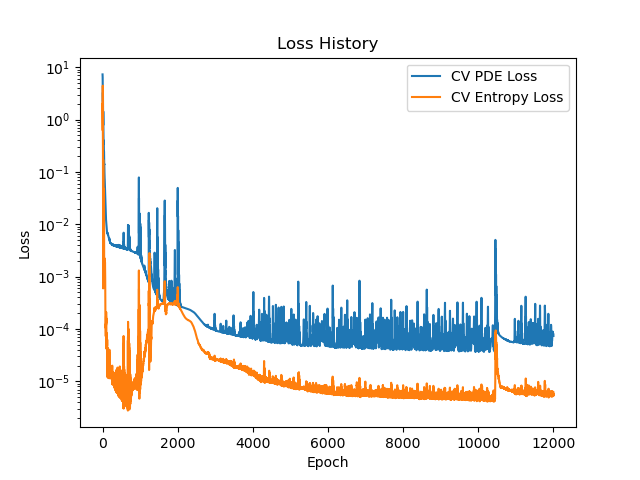

In [7]:
solver.plot_loss_history()

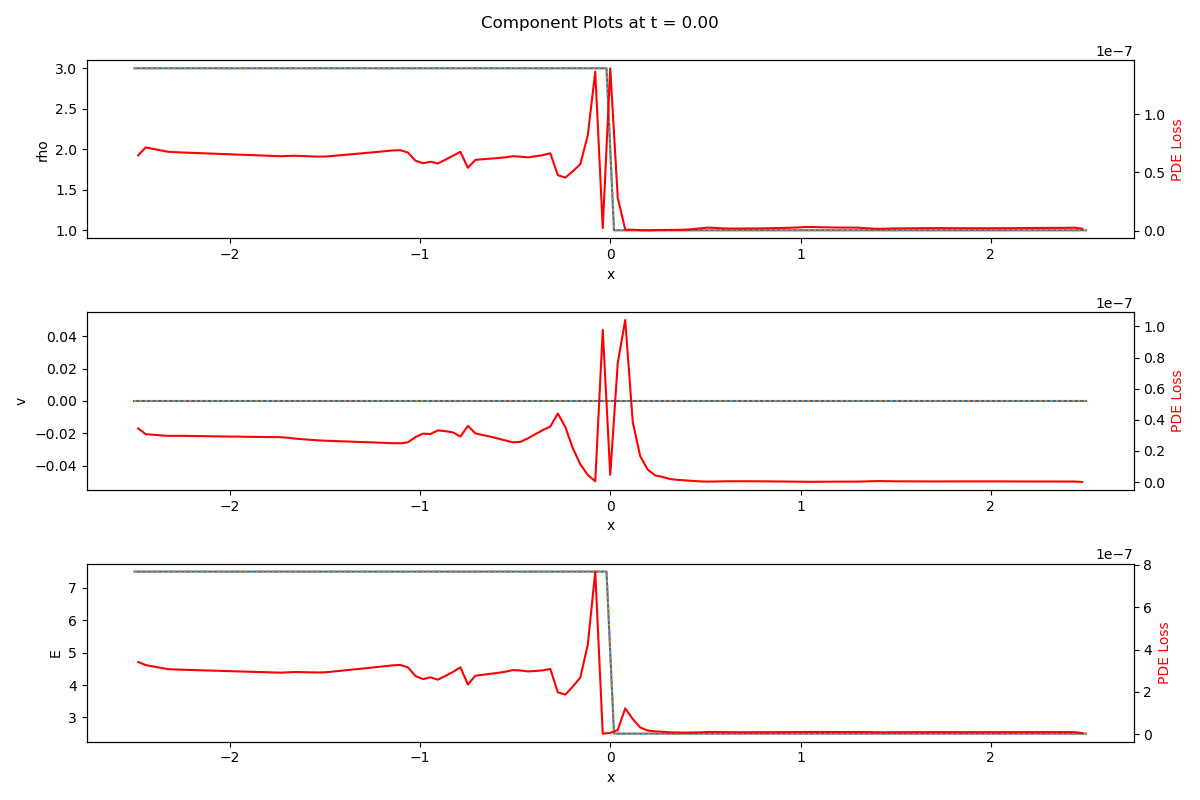

In [8]:
solver.plot_components(
    0,
    num_rows=3,
    num_cols=1,
    centered=False,
    with_ics=True,
    loss_to_plot="PDE",
)

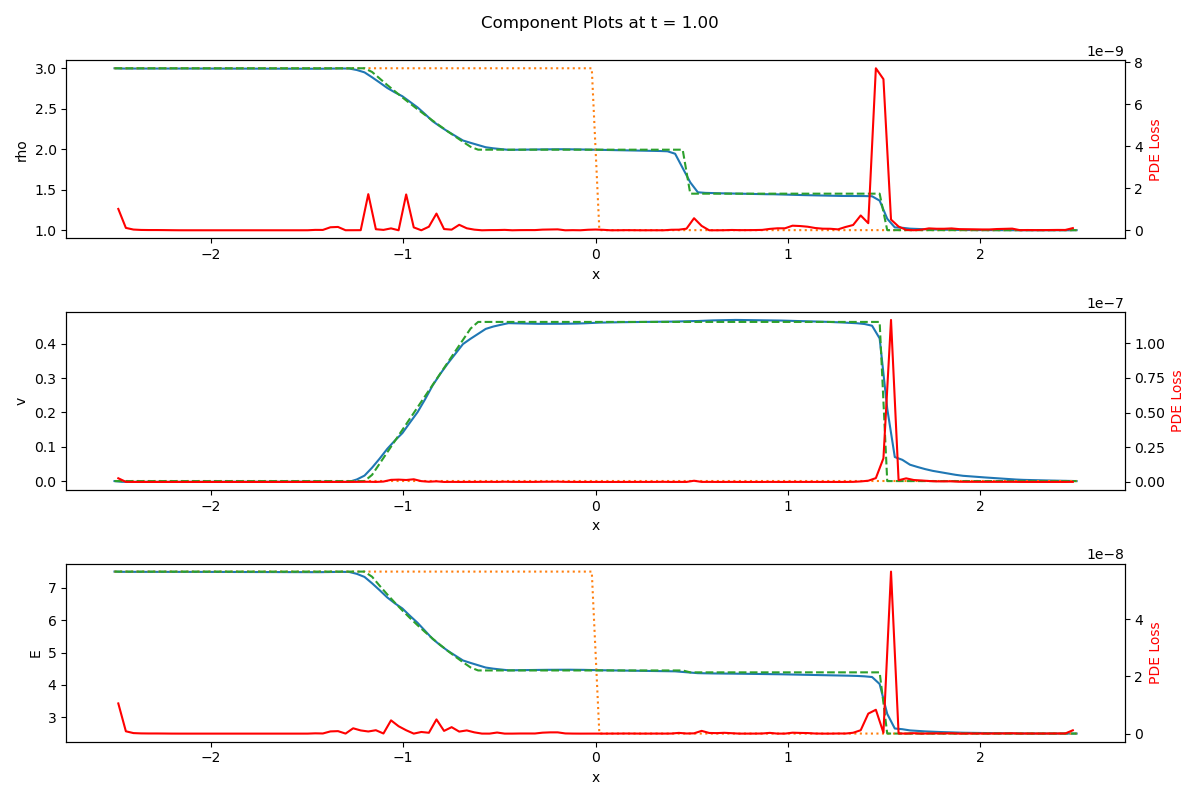

In [9]:
solver.plot_components(
    -1,
    num_rows=3,
    num_cols=1,
    centered=False,
    with_ics=True,
    with_analytic_soln=True,
    loss_to_plot="PDE",
)